In [40]:
import numpy as np
import pandas as pd

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from pandas.tools.plotting import scatter_matrix
 
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

In [41]:
from project import utils
X, test_x, Y = utils.load_data('flipped2', columns=['numberOfDaysActuallyPlayed', 'f__k_4', 'totalScore2', 'f_10',
       'f_old_k_11', 'numberOfAttemptedLevels', 'f_17', 'f_top_to_all2',
       'f__d_6', 'upd_start_level', 'totalBonusScore', 'f_38',
       'averageNumOfTurnsPerCompletedLevel', 'f_old_k_3', 'f_3',
       'last_lvl_completed', 'totalNumOfAttempts2', 'UsefullBoosters2',
       'doReturnOnLowerLevels'])

In [42]:
X.columns

Index(['numberOfDaysActuallyPlayed', 'f__k_4', 'totalScore2', 'f_10',
       'f_old_k_11', 'numberOfAttemptedLevels', 'f_17', 'f_top_to_all2',
       'f__d_6', 'upd_start_level', 'totalBonusScore', 'f_38',
       'averageNumOfTurnsPerCompletedLevel', 'f_old_k_3', 'f_3',
       'last_lvl_completed', 'totalNumOfAttempts2', 'UsefullBoosters2',
       'doReturnOnLowerLevels'],
      dtype='object')

In [44]:
kf = StratifiedKFold(n_splits=5, random_state=2707)
def modelfit(alg, train_x, train_y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_x.values, label=train_y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    print('*', end='')
    logloss_scores = cross_val_score(alg, train_x, train_y, cv=kf, scoring='neg_log_loss', fit_params={'eval_metric':'logloss'})
    print('*', end='')
    print("\nModel Report")
    print("Logloss Score (Train):", -np.mean(logloss_scores))
    print("N :", alg.get_params()['n_estimators'])
    alg.fit(train_x, train_y, eval_metric='logloss')
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg.get_params()['n_estimators']

**
Model Report
Logloss Score (Train): 0.380491972292
N : 60


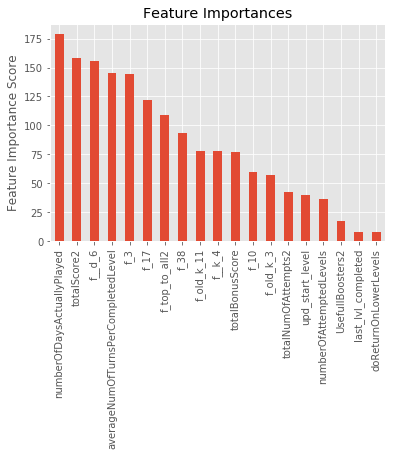

In [45]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=2707)
best_n_estimators = modelfit(xgb1, X, Y)

In [46]:
xgb2 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=best_n_estimators,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)

gsearch1.fit(X, Y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38162, std: 0.00887, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.38165, std: 0.00896, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.38161, std: 0.00880, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.38049, std: 0.00909, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.38015, std: 0.00930, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.38002, std: 0.00947, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.38260, std: 0.00960, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.38316, std: 0.01000, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.38286, std: 0.00994, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.38898, std: 0.01124, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.38788, std: 0.01087, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.38667, std: 0.01014, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [47]:
param_test1 = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[4, 5, 6]
}
gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)

gsearch1.fit(X, Y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38077, std: 0.00868, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.38082, std: 0.00903, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.38035, std: 0.00891, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.38043, std: 0.00948, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.38002, std: 0.00947, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.38034, std: 0.00946, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.38114, std: 0.00966, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.38084, std: 0.00914, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.38062, std: 0.00923, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 5},
 -0.38002389966254962)

In [48]:
# CHECK THAT NOT EDGE CASES!
best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

**
Model Report
Logloss Score (Train): 0.380023899663
N : 60


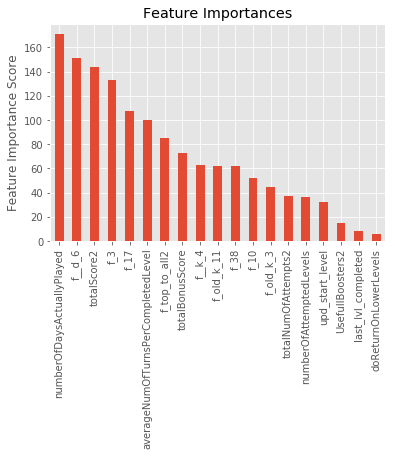

In [49]:
xgb3 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)
best_n_estimators = modelfit(xgb3, X, Y)

In [50]:
param_test3 = {
 'gamma':np.arange(0, 1, 0.025)
}
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch3.fit(X, Y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38002, std: 0.00947, params: {'gamma': 0.0},
  mean: -0.38022, std: 0.00967, params: {'gamma': 0.025000000000000001},
  mean: -0.38037, std: 0.00960, params: {'gamma': 0.050000000000000003},
  mean: -0.38014, std: 0.00937, params: {'gamma': 0.075000000000000011},
  mean: -0.38006, std: 0.00945, params: {'gamma': 0.10000000000000001},
  mean: -0.38026, std: 0.00981, params: {'gamma': 0.125},
  mean: -0.38048, std: 0.00989, params: {'gamma': 0.15000000000000002},
  mean: -0.38050, std: 0.00976, params: {'gamma': 0.17500000000000002},
  mean: -0.38053, std: 0.00952, params: {'gamma': 0.20000000000000001},
  mean: -0.38045, std: 0.00955, params: {'gamma': 0.22500000000000001},
  mean: -0.38046, std: 0.00955, params: {'gamma': 0.25},
  mean: -0.38047, std: 0.00953, params: {'gamma': 0.27500000000000002},
  mean: -0.38033, std: 0.00966, params: {'gamma': 0.30000000000000004},
  mean: -0.38042, std: 0.00974, params: {'gamma': 0.32500000000000001},
  mean: -0.38039, std: 0.00965, pa

In [51]:
best_gamma = gsearch3.best_params_['gamma']

In [52]:
xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)

param_test4 = {
 'subsample': np.arange(0.5, 1, 0.1),
 'colsample_bytree': np.arange(0.5, 1, 0.1),
}

gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch4.fit(X, Y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38202, std: 0.00886, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: -0.38191, std: 0.00896, params: {'colsample_bytree': 0.5, 'subsample': 0.59999999999999998},
  mean: -0.38112, std: 0.00922, params: {'colsample_bytree': 0.5, 'subsample': 0.69999999999999996},
  mean: -0.38104, std: 0.00945, params: {'colsample_bytree': 0.5, 'subsample': 0.79999999999999993},
  mean: -0.38091, std: 0.00949, params: {'colsample_bytree': 0.5, 'subsample': 0.89999999999999991},
  mean: -0.38173, std: 0.00868, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.5},
  mean: -0.38108, std: 0.00867, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.59999999999999998},
  mean: -0.38116, std: 0.00965, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.69999999999999996},
  mean: -0.38089, std: 0.01007, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.79999999999999993},
  mean: -0.38057, std: 0.00933, params: {'colsample_bytree'

In [53]:
param_test4 = {
 'subsample': np.arange(0.745, 0.85, 0.025),
 'colsample_bytree': np.arange(0.75, 0.85, 0.025),
}

gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch4.fit(X, Y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38080, std: 0.00942, params: {'colsample_bytree': 0.75, 'subsample': 0.745},
  mean: -0.38089, std: 0.00943, params: {'colsample_bytree': 0.75, 'subsample': 0.77000000000000002},
  mean: -0.38033, std: 0.00929, params: {'colsample_bytree': 0.75, 'subsample': 0.79500000000000004},
  mean: -0.38019, std: 0.00913, params: {'colsample_bytree': 0.75, 'subsample': 0.82000000000000006},
  mean: -0.38068, std: 0.00939, params: {'colsample_bytree': 0.75, 'subsample': 0.84500000000000008},
  mean: -0.38080, std: 0.00942, params: {'colsample_bytree': 0.77500000000000002, 'subsample': 0.745},
  mean: -0.38089, std: 0.00943, params: {'colsample_bytree': 0.77500000000000002, 'subsample': 0.77000000000000002},
  mean: -0.38033, std: 0.00929, params: {'colsample_bytree': 0.77500000000000002, 'subsample': 0.79500000000000004},
  mean: -0.38019, std: 0.00913, params: {'colsample_bytree': 0.77500000000000002, 'subsample': 0.82000000000000006},
  mean: -0.38068, std: 0.00939, params: {'colsampl

In [54]:
best_colsample_bytree = gsearch4.best_params_['colsample_bytree']
best_subsample = gsearch4.best_params_['subsample']

In [55]:
xgb_5 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)

In [56]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = xgb_5, param_grid = param_test5, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch5.fit(X, Y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38019, std: 0.00913, params: {'reg_alpha': 1e-05},
  mean: -0.38067, std: 0.00917, params: {'reg_alpha': 0.01},
  mean: -0.38040, std: 0.00925, params: {'reg_alpha': 0.1},
  mean: -0.38048, std: 0.00934, params: {'reg_alpha': 1},
  mean: -0.38841, std: 0.00739, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 -0.38018503575524265)

In [57]:
param_test5 = {
 'reg_alpha':np.arange(0, 0.05, 0.025),
}
gsearch5 = GridSearchCV(estimator = xgb_5, param_grid = param_test5, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch5.fit(X, Y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38019, std: 0.00913, params: {'reg_alpha': 0.0},
  mean: -0.38037, std: 0.00908, params: {'reg_alpha': 0.025000000000000001}],
 {'reg_alpha': 0.0},
 -0.38018503729277875)

In [58]:
best_reg_alpha = gsearch5.best_params_['reg_alpha']

In [59]:
xgb_6 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha = best_reg_alpha,
    
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)

In [60]:
param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 2, 3, 5, 10, 100]
}
gsearch6 = GridSearchCV(estimator = xgb_6, param_grid = param_test6, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch6.fit(X, Y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38074, std: 0.00958, params: {'reg_lambda': 1e-05},
  mean: -0.38077, std: 0.00940, params: {'reg_lambda': 0.01},
  mean: -0.38056, std: 0.00909, params: {'reg_lambda': 0.1},
  mean: -0.38019, std: 0.00913, params: {'reg_lambda': 1},
  mean: -0.38067, std: 0.00909, params: {'reg_lambda': 2},
  mean: -0.38077, std: 0.00933, params: {'reg_lambda': 3},
  mean: -0.38080, std: 0.00917, params: {'reg_lambda': 5},
  mean: -0.38062, std: 0.00912, params: {'reg_lambda': 10},
  mean: -0.38237, std: 0.00843, params: {'reg_lambda': 100}],
 {'reg_lambda': 1},
 -0.38018503729277875)

In [61]:
param_test6 = {
 'reg_lambda':np.arange(0.5,1.5,0.1)
}
gsearch6 = GridSearchCV(estimator = xgb_6, param_grid = param_test6, scoring='neg_log_loss', n_jobs=4, iid=False, cv=kf)
gsearch6.fit(X, Y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Anaconda3\envs\env_name34\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38040, std: 0.00920, params: {'reg_lambda': 0.5},
  mean: -0.38064, std: 0.00928, params: {'reg_lambda': 0.59999999999999998},
  mean: -0.38077, std: 0.00935, params: {'reg_lambda': 0.69999999999999996},
  mean: -0.38060, std: 0.00941, params: {'reg_lambda': 0.79999999999999993},
  mean: -0.38039, std: 0.00915, params: {'reg_lambda': 0.89999999999999991},
  mean: -0.38019, std: 0.00913, params: {'reg_lambda': 0.99999999999999989},
  mean: -0.38069, std: 0.00936, params: {'reg_lambda': 1.0999999999999999},
  mean: -0.38033, std: 0.00905, params: {'reg_lambda': 1.1999999999999997},
  mean: -0.38046, std: 0.00912, params: {'reg_lambda': 1.2999999999999998},
  mean: -0.38083, std: 0.00923, params: {'reg_lambda': 1.3999999999999999}],
 {'reg_lambda': 0.99999999999999989},
 -0.38018503729277875)

In [62]:
best_reg_lambda = gsearch6.best_params_['reg_lambda']

**
Model Report
Logloss Score (Train): 0.379901531214
N : 1421


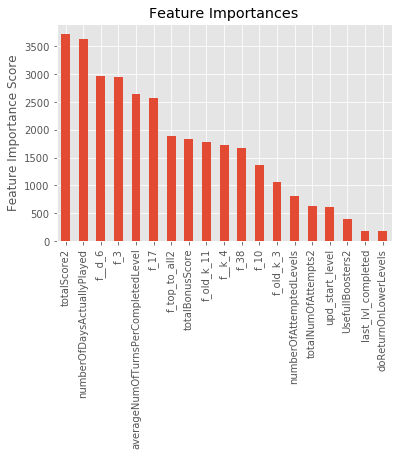

In [67]:
xgb_fin = xgb.XGBClassifier(
    learning_rate =0.005,
    n_estimators=2000,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha = best_reg_alpha,
    reg_lambda = best_reg_lambda,
    
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)
best_n_estimators = modelfit(xgb_fin, X, Y)

**
Model Report
Logloss Score (Train): 0.37987607905
N : 725


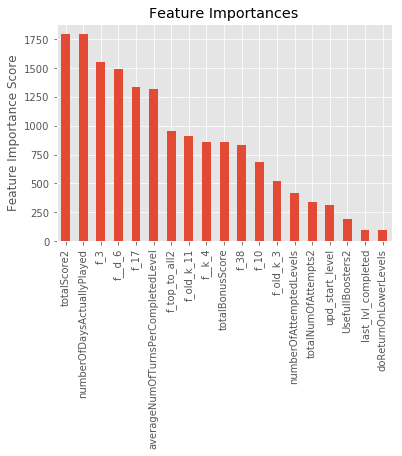

In [64]:
xgb_fin = xgb.XGBClassifier(
    learning_rate =0.01,
    n_estimators=2000,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha = best_reg_alpha,
    reg_lambda = best_reg_lambda,
    
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=2707
)
best_n_estimators = modelfit(xgb_fin, X, Y)

In [65]:
xgb_fin.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.75,
 'gamma': 0.0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 725,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0.0,
 'reg_lambda': 0.99999999999999989,
 'scale_pos_weight': 1,
 'seed': 2707,
 'silent': True,
 'subsample': 0.82000000000000006}